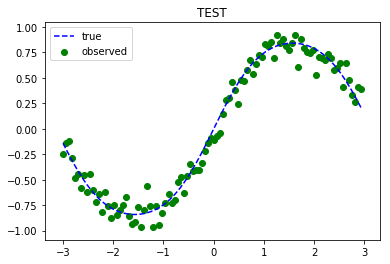

In [211]:
N_Reconfigurations = 10**1
d = 1 # Dimension of X
D = 1 # Dimension of Y

# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.9

# Training meta-parameters
Epochs = 5


# Number of Datapoints
N_data = 10**2
# Unknown Function
def unknown_f(x):
    return np.sin(np.sin(x))
%run Data_Generator.ipynb

In [212]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

In [213]:
np.shape(NEU_targets)

(100, 1)

# NEU (Reconfigurations Map and Related Functions)

## **Note:** 
### Run Regression or PCA not this code...this is backend and relies on those to initialize parameters....

## Initialize Modules

###### Imports

In [214]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
from keras import backend as Kback
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils

# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
# import tkinter
# from tkinter import messagebox
import os as beepsnd

# General Outputs
print('TensorFlow:', tf.__version__)

TensorFlow: 2.1.0


### Define Reconfiguration Unit

1. Shifts $x \in \mathbb{R}^d$ to $x- c$; c trainable.
2. Rescales componentwise with $a * x$,  $a \in \mathbb{R}^d$ trainable.
3. Applies the map $\psi(x)\triangleq e^{\frac1{1-|x|}}I_{\{|x|<1\}}$ component-wise.  
4. Applies transformation $x \mapsto x +b$, $b \in \mathbb{R}^d$ trainable.
5. Applies the diagonalization map to that output: $ \left(x_1,\dots,x_d\right)\mapsto
                \begin{pmatrix}
                x_1 & & 0\\
                &\ddots &\\
                0 & & x_d\\
                \end{pmatrix}.$
6. Applies map $X \mapsto XA$, $A$ is a trainable $d\times d$ matrix.
7. Applies matrix exponential.
8. Multiplies output with result of (1).
9. Re-centers output to $x +c$ where $c$ is as in (1).

In [204]:
class Reconfiguration_unit_steps_1_2(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps_1_2, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.location = self.add_weight(name='location',
                                    shape=input_shape[1:],
                                    initializer='GlorotUniform',
                                    trainable=True)
        self.scale = self.add_weight(name='scale',
                                    shape=[d+D,d+D],
                                    initializer='GlorotUniform',
                                    trainable=True)
        
    def call(self, input):
        # Relocated
        input_relocated = input + self.location
        # Rescaled
        output_steps_1_2 = tf.linalg.matvec(self.scale,input_relocated)
        # Return Ouput
        return output_steps_1_2

In [475]:
class Reconfiguration_unit_steps_3(tf.keras.layers.Layer):

    def __init__(self, *args, **kwargs):
        super(Reconfiguration_unit_steps_3, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.threshold_level = self.add_weight(name='threshlevel',
                                    shape=[1],
                                    initializer='GlorotUniform',
                                    trainable=True)
        
    def f_True(x):
        # Compute Bump Function
        bump_value = 1-tf.math.pow(x,2)
        bump_value = -tf.math.pow(bump_value,-1)
        bump_value = tf.math.exp(bump_value)
        return(bump_value)
    
    def f_False(x):
        # Compute Bump Function
        x_out = 0*x
        return(x_out)
        
    def call(self, input):        
        # Apply Logic_Gate
        output_step_3 = tf.math.multiply(input,self.threshold_level)
        #output_step_3 = tf.cond(tf.math.less(tf.math.abs(input),1), lambda: f_False(input), lambda: f_False(input))
        output_step_3 = tf.math.multiply(input,tf.math.pow(self.threshold_level,-1))
        return output_step_3

In [476]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

In [477]:
# Initialize
input_layer = tf.keras.Input(shape=[d+D])
# Steps 1 and 2
current_layer  = Reconfiguration_unit_steps_1_2()(input_layer)
# Step 3
current_layer  = Reconfiguration_unit_steps_3()(current_layer)
# Map back to R^D
output_layer = projection_layer(current_layer)
NEU_OLS = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
# Summarize Model
NEU_OLS.summary()

NameError: in converted code:

    <ipython-input-475-982ffb2d6ea6>:26 call  *
        output_step_3 = threshold_level*input

    NameError: name 'threshold_level' is not defined


In [471]:
NEU_OLS.compile(loss='mse',
                optimizer="SGD",
                metrics=['mae', 'mse'])

In [472]:
history = NEU_OLS.fit(
          data_NEU, NEU_targets,
          epochs=Epochs)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 0s 3ms/sample - loss: 0.3875 - mae: 0.5110 - mse: 0.3875
Epoch 2/5
100/100 [==============================] - 0s 104us/sample - loss: 0.3685 - mae: 0.4950 - mse: 0.3685
Epoch 3/5
100/100 [==============================] - 0s 157us/sample - loss: 0.3541 - mae: 0.4850 - mse: 0.3541
Epoch 4/5
100/100 [==============================] - 0s 173us/sample - loss: 0.3412 - mae: 0.4728 - mse: 0.3412
Epoch 5/5
100/100 [==============================] - 0s 153us/sample - loss: 0.3310 - mae: 0.4672 - mse: 0.3310


In [473]:
# Projection
NEU_prediction = NEU_OLS.predict(data_NEU)

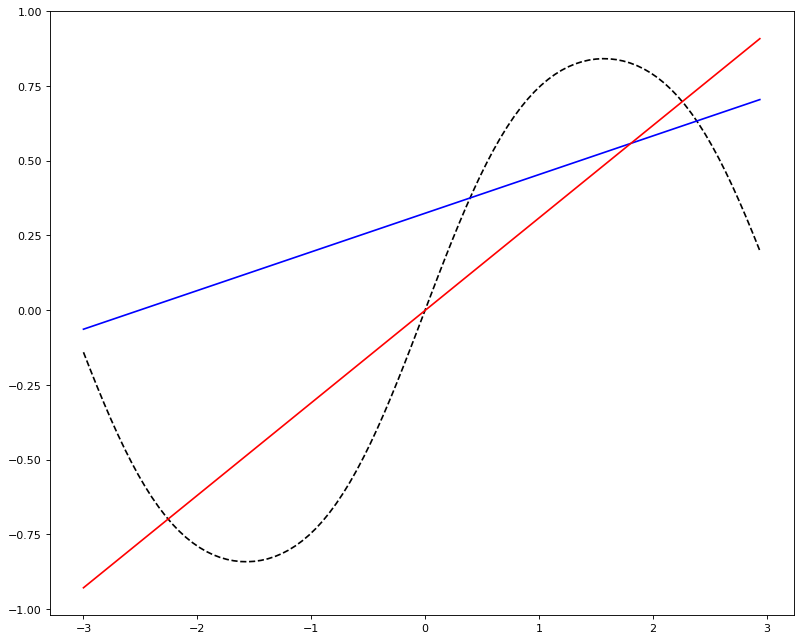

In [474]:
# import matplotlib.pyplot as plt
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Plot Models
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')
plt.plot(data_x,NEU_prediction,color='b',label='NEU-OLS')
plt.plot(data_x,model_pred_y,color='r',label='NEU-OLS')